In [1]:
# ================================================================
# Bachelor Thesis — Fairness in Toxic Comment Classification
# ---------------------------------------------------------------
# Notebook: eo_model_calculations_and_evaluation.ipynb
# Author: Philipp Stocker
# Created: 21.12.2025
# Purpose: TODO: fill purpose
# ================================================================

# --- Basic setup ---
import os
import sys
import warnings
warnings.filterwarnings("ignore")  # keep output clean for reports

# Automatically add project root to path so src/ modules are importable
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Standard imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib

from src.modeling import predict_with_model
from src.modeling import extract_feature_and_label_arrays
from src.modeling import find_best_threshold

from src.metrics import compute_overall_metrics
from src.metrics import evaluate_subgroups

from src.bias_mitigation import fit_equalized_odds_postprocessor, apply_equalized_odds_postprocessor

from src.visualization import (
    plot_performance_bar,
    plot_roc_curve,
    plot_pr_curve,
    plot_confusion_matrix,
    plot_auc_bars,
    plot_rate_gaps_bars,
    print_small_sample_warnings
)

# --- "Global variables" ---
DATA_RAW = os.path.join(project_root, "data", "raw")
DATA_PROCESSED = os.path.join(project_root, "data", "processed")

IDENTITY_COLUMNS = ["male", "female", "heterosexual", "homosexual_gay_or_lesbian", "bisexual", "transgender", "other_gender", "other_sexual_orientation"]

print("✅ Environment ready")


✅ Environment ready


DATA PREPARATION

Load necessary, already existing data:

In [2]:
x_train, y_train = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "train_tfidf_bundle.joblib")))
x_val_threshold, y_val_threshold = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "val_threshold_tfidf_bundle.joblib")))
x_val_eo, y_val_eo = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "val_eo_tfidf_bundle.joblib")))
x_test, y_test = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "test_tfidf_bundle.joblib")))

# Load processed dataframes from parquet file
val_df_eo = pd.read_parquet(os.path.join(DATA_PROCESSED, "val_eo_processed.parquet"))
test_df = pd.read_parquet(os.path.join(DATA_PROCESSED, "test_processed.parquet"))
# Ensure that processed comment texts are strings and handle any missing values
val_df_eo["comment_text_processed"] = val_df_eo["comment_text_processed"].astype(str).fillna("")
test_df["comment_text_processed"] = test_df["comment_text_processed"].astype(str).fillna("")

# Load trained base models for probability predictions
base_models = joblib.load(project_root + "/models/tfidf_base_models.joblib")

Calculate best threshold based on f1 score:

In [3]:
y_val_threshold_proba, _ = predict_with_model(base_models["model"], x_val_threshold, threshold=0.5)

threshold = find_best_threshold(y_val_threshold, y_val_threshold_proba)

Best threshold: 0.25 with F1-score: 0.6447


Calculate probability and conduct baseline predictions without equalized odds on validation-split and on test-dataset:

In [4]:
y_val_proba_base, y_val_pred_base = predict_with_model(base_models["model"], x_val_eo, threshold=threshold)
y_test_proba_base, y_test_pred_base = predict_with_model(base_models["model"], x_test, threshold=threshold)


POST-PROCESSING EQUALIZED ODDS APPLICATION

In [5]:
val_df_t = pd.read_parquet(os.path.join(DATA_PROCESSED, "val_threshold_processed.parquet"))
val_df_t.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,labelled_as_toxic,has_identity,comment_text_processed
0,5280229,0.9,Yep straight shooting himself in the foot.,0.2,0.0,0.0,0.0,0.9,NaN,NaN,...,0,0,3,0,0.0,0,10,1,0,yep straight shooting himself in the foot
1,772588,0.0,The main stream media and the interests direct...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,1,29,16,0.0,0,4,0,0,the main stream media and the interests direct...
2,5247773,0.0,Plus Richmond has awesome Chinese food.,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0,0,0.0,0,4,0,0,plus richmond has awesome chinese food
3,440995,0.0,"To be fair, most trips like those do carry hef...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0,0,0.0,0,4,0,0,to be fair most trips like those do carry heft...
4,6102970,0.0,It hasn't. When the inevitable bill comes into...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,1,18,0,0.0,0,4,0,0,it hasn't when the inevitable bill comes into ...


Fit fairlearn Equalized Odds post-processor on validation predictions and labels:

In [6]:
bundle_gender_eo = fit_equalized_odds_postprocessor(
    y_val=y_val_eo,
    y_val_proba=y_val_proba_base,
    val_df=val_df_eo,
    sensitive_attribute="gender",
    identity_threshold=0.5,
    base_threshold=threshold
)

bundle_sexual_orientation_eo = fit_equalized_odds_postprocessor(
    y_val=y_val_eo,
    y_val_proba=y_val_proba_base,
    val_df=val_df_eo,
    sensitive_attribute="sexual_orientation",
    identity_threshold=0.5,
    base_threshold=threshold
)

Equalized Odds sensitive feature derivation (gender)
  included female: 2521
  included male: 1838
  excluded none: 129790
  excluded both: 1217
Fitting Equalized Odds post-processor
  sensitive_attribute: gender
  identity_threshold: 0.5
  included rows: 4359
  excluded rows: 131007
Equalized Odds sensitive feature derivation (sexual orientation)
  included homosexual_gay_or_lesbian: 719
  included transgender: 167
  included background (no identity mention): 129134
  excluded other identity mentions: 5346
Fitting Equalized Odds post-processor
  sensitive_attribute: sexual_orientation
  identity_threshold: 0.5
  included rows: 130020
  excluded rows: 5346


Apply Equalized Odds on validation split (for diagnostics):

In [7]:
y_val_pred_gender = apply_equalized_odds_postprocessor(
    postprocessor_bundle=bundle_gender_eo,
    y_proba=y_val_proba_base,
    df=val_df_eo
)

y_val_pred_sexual_orientation = apply_equalized_odds_postprocessor(
    postprocessor_bundle=bundle_sexual_orientation_eo,
    y_proba=y_val_proba_base,
    df=val_df_eo
)

Equalized Odds sensitive feature derivation (gender)
  included female: 2521
  included male: 1838
  excluded none: 129790
  excluded both: 1217
Applying Equalized Odds post-processor
  sensitive_attribute: gender
  identity_threshold: 0.5
  included rows: 4359
  excluded rows (fallback thresholding): 131007
  fallback base_threshold: 0.24999999999999994
Equalized Odds sensitive feature derivation (sexual orientation)
  included homosexual_gay_or_lesbian: 719
  included transgender: 167
  included background (no identity mention): 129134
  excluded other identity mentions: 5346
Applying Equalized Odds post-processor
  sensitive_attribute: sexual_orientation
  identity_threshold: 0.5
  included rows: 130020
  excluded rows (fallback thresholding): 5346
  fallback base_threshold: 0.24999999999999994


Apply Equalized Odds on test data:

In [8]:
y_test_pred_eo_gender = apply_equalized_odds_postprocessor(
    postprocessor_bundle=bundle_gender_eo,
    y_proba=y_test_proba_base,
    df=test_df
)

y_test_pred_eo_sexual_orientation = apply_equalized_odds_postprocessor(
    postprocessor_bundle=bundle_sexual_orientation_eo,
    y_proba=y_test_proba_base,
    df=test_df
)

Equalized Odds sensitive feature derivation (gender)
  included female: 5190
  included male: 3462
  excluded none: 259588
  excluded both: 2491
Applying Equalized Odds post-processor
  sensitive_attribute: gender
  identity_threshold: 0.5
  included rows: 8652
  excluded rows (fallback thresholding): 262079
  fallback base_threshold: 0.24999999999999994
Equalized Odds sensitive feature derivation (sexual orientation)
  included homosexual_gay_or_lesbian: 1429
  included transgender: 316
  included background (no identity mention): 258267
  excluded other identity mentions: 10719
Applying Equalized Odds post-processor
  sensitive_attribute: sexual_orientation
  identity_threshold: 0.5
  included rows: 260012
  excluded rows (fallback thresholding): 10719
  fallback base_threshold: 0.24999999999999994


EO MODEL PERFORMANCE METRICS

Calculate baseline performance metrics:

In [9]:
base_model_overall_metrics = compute_overall_metrics(y_test, y_test_pred_base, y_test_proba_base)

print("Overall metrics for base model:")
print(base_model_overall_metrics)

Overall metrics for base model:
{'accuracy': 0.94105588203789, 'precision': 0.6256122854242973, 'recall': 0.6547965451942174, 'f1_score': 0.6398718180176928, 'roc_auc': 0.9483893764015319, 'pr_auc': 0.6974232009378413}


Calculate gender EO performance metrics:

In [10]:
eo_gender_overall_metrics = compute_overall_metrics(y_test, y_test_pred_eo_gender, y_test_proba_base)

print("Overall metrics for base model with gender-sensitive Equalized Odds:")
print(eo_gender_overall_metrics)

Overall metrics for base model with gender-sensitive Equalized Odds:
{'accuracy': 0.9414732705157518, 'precision': 0.6319425506772112, 'recall': 0.6421874278324327, 'f1_score': 0.6370238013424049, 'roc_auc': 0.9483893764015319, 'pr_auc': 0.6974232009378413}


Calculate sexual orientation EO performance metrics:

In [11]:
eo_sexual_orientation_overall_metrics = compute_overall_metrics(y_test, y_test_pred_eo_sexual_orientation, y_test_proba_base)

print("Overall metrics for base model with sexual orientation-sensitive Equalized Odds:")
print(eo_sexual_orientation_overall_metrics)

Overall metrics for base model with sexual orientation-sensitive Equalized Odds:
{'accuracy': 0.9215900654154863, 'precision': 0.5718654434250765, 'recall': 0.07773313010946377, 'f1_score': 0.13686264942668944, 'roc_auc': 0.9483893764015319, 'pr_auc': 0.6974232009378413}


Visualize performance metrics

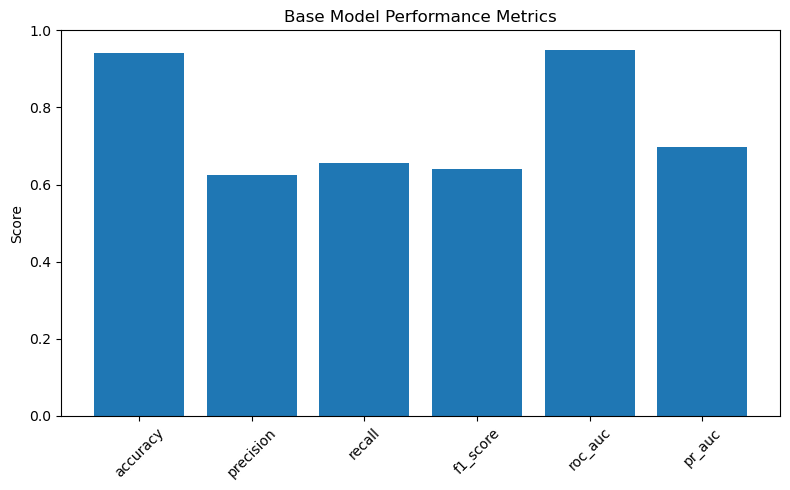

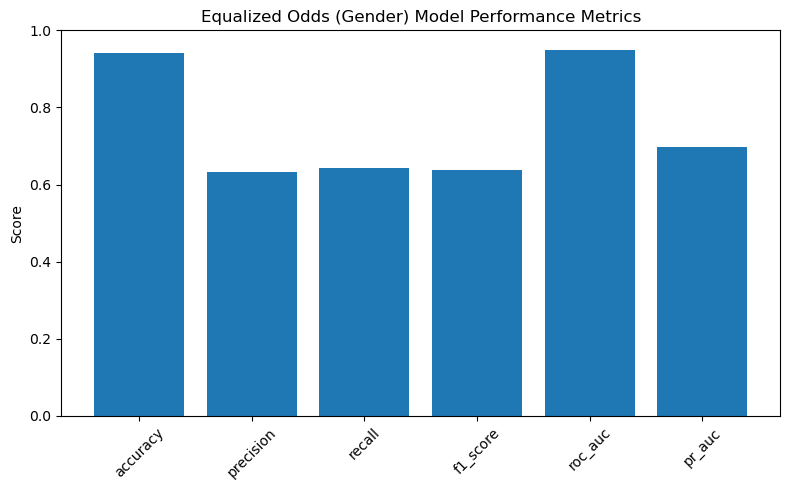

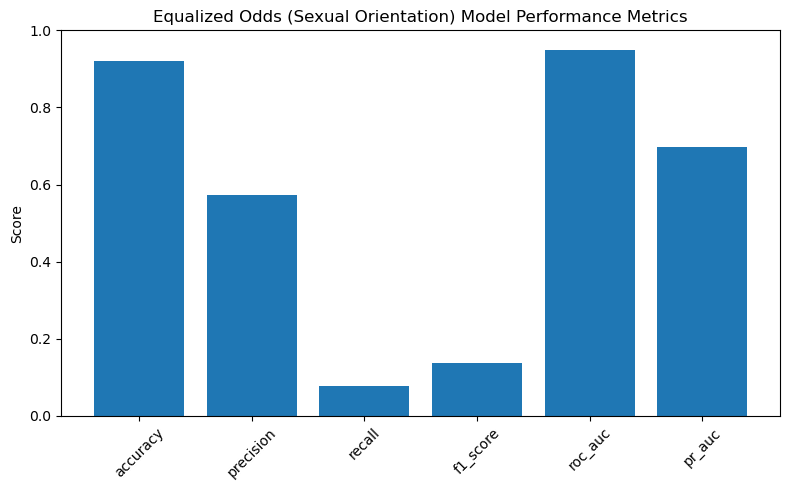

In [12]:
# Plot performance bars
plot_performance_bar(base_model_overall_metrics, title="Base Model Performance Metrics")
plot_performance_bar(eo_gender_overall_metrics, title="Equalized Odds (Gender) Model Performance Metrics")
plot_performance_bar(eo_sexual_orientation_overall_metrics, title="Equalized Odds (Sexual Orientation) Model Performance Metrics")

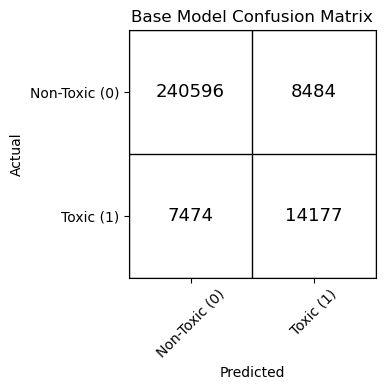

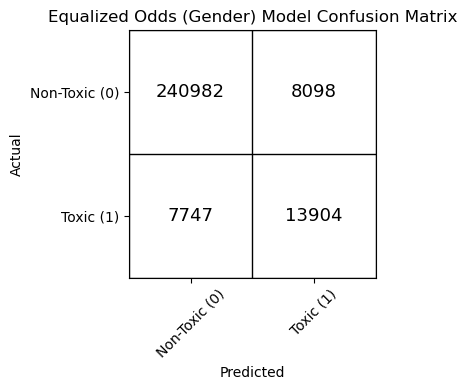

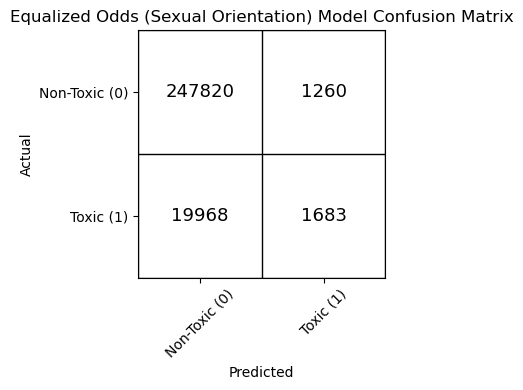

In [13]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred_base, title="Base Model Confusion Matrix")
plot_confusion_matrix(y_test, y_test_pred_eo_gender, title="Equalized Odds (Gender) Model Confusion Matrix")
plot_confusion_matrix(y_test, y_test_pred_eo_sexual_orientation, title="Equalized Odds (Sexual Orientation) Model Confusion Matrix")

EO MODEL FAIRNESS METRICS

Calculate fairness Metrics (per subgroup)

In [14]:
# Prepare test dataframe with predictions for subgroup evaluation
test_df = pd.read_parquet(os.path.join(DATA_PROCESSED, "test_processed.parquet")).copy()
test_df["predicted_proba"] = y_test_proba_base
test_df["predicted_label"] = y_test_pred_base
test_df["predicted_label_with_eo_gender"] = y_test_pred_eo_gender
test_df["predicted_label_with_eo_sexual_orientation"] = y_test_pred_eo_sexual_orientation

test_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,sexual_explicit,identity_annotator_count,toxicity_annotator_count,labelled_as_toxic,has_identity,comment_text_processed,predicted_proba,predicted_label,predicted_label_with_eo_gender,predicted_label_with_eo_sexual_orientation
0,5555389,0.1,I listened to Scheer re Omar Khadr; he sounded...,0.0,0.0,0.1,0.1,0.0,NaN,NaN,...,0.0,0,10,0,0,i listened to scheer re omar khadr he sounded ...,0.044897,0,0,0
1,376072,0.0,For more on Pre check out; prespeople.com,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0,4,0,0,for more on pre check out prespeople com,0.002610,0,0,0
2,539767,0.4,They also have to go to places where people sh...,0.1,0.0,0.0,0.0,0.4,NaN,NaN,...,0.0,0,10,0,0,they also have to go to places where people sh...,0.384593,1,1,0
3,5556650,0.0,This is why many experts and policy makers are...,0.0,0.0,0.2,0.0,0.0,NaN,NaN,...,0.0,0,5,0,0,this is why many experts and policy makers are...,0.008390,0,0,0
4,333126,0.0,"Yeah, I know...many regular miles as well.",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0,4,0,0,yeah i know many regular miles as well,0.010261,0,0,0


In [15]:
# Conduct subgroup evaluation for base model
base_subgroup_metrics_df = evaluate_subgroups(
    df=test_df,
    subgroup_cols=IDENTITY_COLUMNS,
    threshold=threshold
)

print(base_subgroup_metrics_df)

                    subgroup  n_subgroup    n_bg  n_sg_pos  n_sg_neg  \
0               heterosexual         189  270542        37       152   
1                   bisexual          38  270693         6        32   
2  homosexual_gay_or_lesbian        1604  269127       454      1150   
3                transgender         353  270378        88       265   
4                       male        6640  264091       985      5655   
5                     female        8107  262624      1093      7014   
6               other_gender           1  270730         0         1   
7   other_sexual_orientation           3  270728         3         0   

   subgroup_auc  bpsn_auc  bnsp_auc    sg_fpr    sg_fnr    bg_fpr    bg_fnr  \
0      0.730441  0.790553  0.945316  0.230263  0.513514  0.033942  0.344915   
1      0.765625  0.805735  0.945282  0.218750  0.666667  0.034038  0.345114   
2      0.777140  0.756498  0.964996  0.268696  0.314978  0.032973  0.345851   
3      0.816381  0.809262  0.958938

In [16]:
# Conduct subgroup evaluation for base model with Equalized Odds (gender)
eo_gender_subgroup_metrics_df = evaluate_subgroups(
    df=test_df,
    subgroup_cols=IDENTITY_COLUMNS,
    y_pred_col="predicted_label_with_eo_gender",
    threshold=threshold
)

print(eo_gender_subgroup_metrics_df)

                    subgroup  n_subgroup    n_bg  n_sg_pos  n_sg_neg  \
0               heterosexual         189  270542        37       152   
1                   bisexual          38  270693         6        32   
2  homosexual_gay_or_lesbian        1604  269127       454      1150   
3                transgender         353  270378        88       265   
4                       male        6640  264091       985      5655   
5                     female        8107  262624      1093      7014   
6               other_gender           1  270730         0         1   
7   other_sexual_orientation           3  270728         3         0   

   subgroup_auc  bpsn_auc  bnsp_auc    sg_fpr    sg_fnr    bg_fpr    bg_fnr  \
0      0.730441  0.790553  0.945316  0.190789  0.594595  0.032415  0.357407   
1      0.765625  0.805735  0.945282  0.218750  0.666667  0.032488  0.357727   
2      0.777140  0.756498  0.964996  0.238261  0.381057  0.031557  0.357315   
3      0.816381  0.809262  0.958938

In [17]:
# Conduct subgroup evaluation for base model with Equalized Odds (sexual orientation)
eo_sexual_orientation_subgroup_metrics_df = evaluate_subgroups(
    df=test_df,
    subgroup_cols=IDENTITY_COLUMNS,
    y_pred_col="predicted_label_with_eo_sexual_orientation",
    threshold=threshold
)

print(eo_sexual_orientation_subgroup_metrics_df)

                    subgroup  n_subgroup    n_bg  n_sg_pos  n_sg_neg  \
0               heterosexual         189  270542        37       152   
1                   bisexual          38  270693         6        32   
2  homosexual_gay_or_lesbian        1604  269127       454      1150   
3                transgender         353  270378        88       265   
4                       male        6640  264091       985      5655   
5                     female        8107  262624      1093      7014   
6               other_gender           1  270730         0         1   
7   other_sexual_orientation           3  270728         3         0   

   subgroup_auc  bpsn_auc  bnsp_auc    sg_fpr    sg_fnr    bg_fpr    bg_fnr  \
0      0.730441  0.790553  0.945316  0.046053  0.837838  0.005034  0.922411   
1      0.765625  0.805735  0.945282  0.000000  0.833333  0.005059  0.922292   
2      0.777140  0.756498  0.964996  0.005217  0.944934  0.005058  0.921781   
3      0.816381  0.809262  0.958938

Visualize fairness metrics (per subgroup)

In [18]:
# Print warnings indicating subgroups with small sample sizes
# This helps to identify potential issues with metric stability due to limited data
print_small_sample_warnings(base_subgroup_metrics_df)
print()
print_small_sample_warnings(eo_gender_subgroup_metrics_df)
print()
print_small_sample_warnings(eo_sexual_orientation_subgroup_metrics_df)

[WARN] bisexual: small sample -> n_subgroup=38
[WARN] other_gender: small sample -> n_subgroup=1, n_sg_pos=0, n_sg_neg=1
[WARN] other_sexual_orientation: small sample -> n_subgroup=3, n_sg_pos=3, n_sg_neg=0

[WARN] bisexual: small sample -> n_subgroup=38
[WARN] other_gender: small sample -> n_subgroup=1, n_sg_pos=0, n_sg_neg=1
[WARN] other_sexual_orientation: small sample -> n_subgroup=3, n_sg_pos=3, n_sg_neg=0

[WARN] bisexual: small sample -> n_subgroup=38
[WARN] other_gender: small sample -> n_subgroup=1, n_sg_pos=0, n_sg_neg=1
[WARN] other_sexual_orientation: small sample -> n_subgroup=3, n_sg_pos=3, n_sg_neg=0


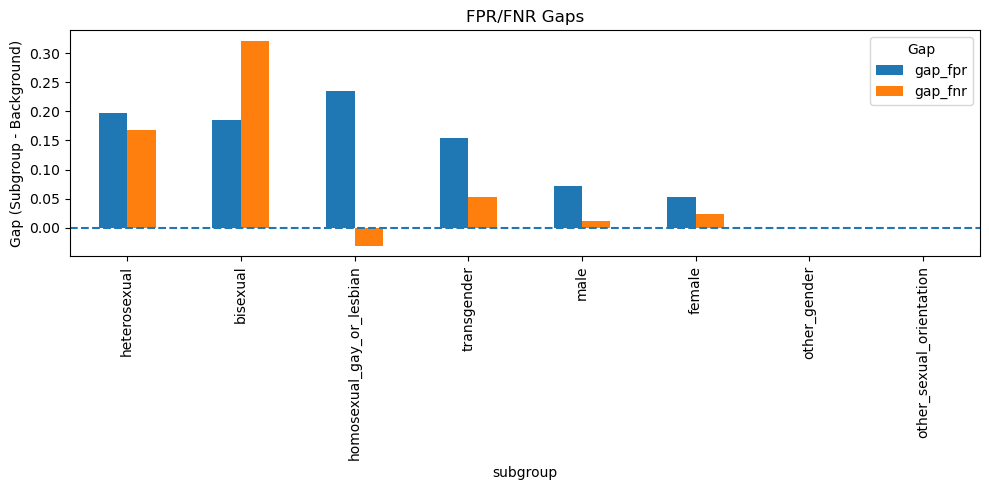

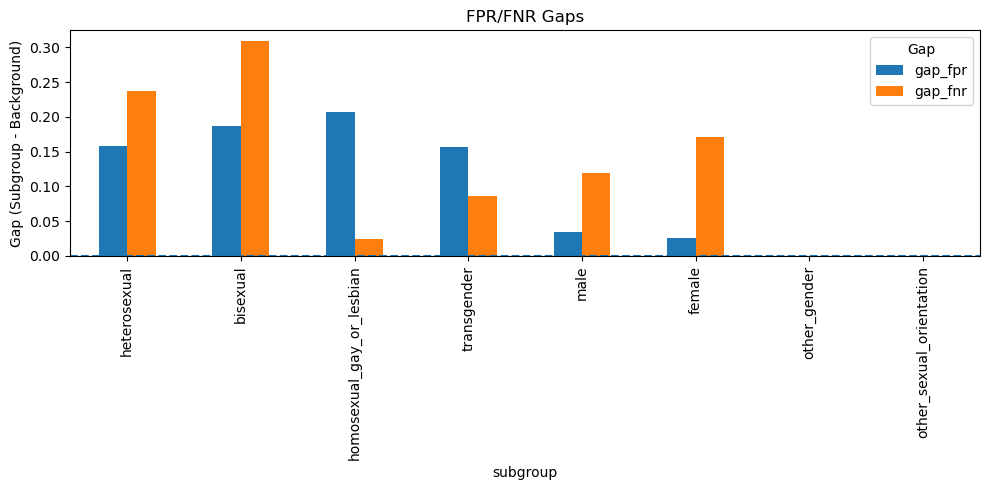

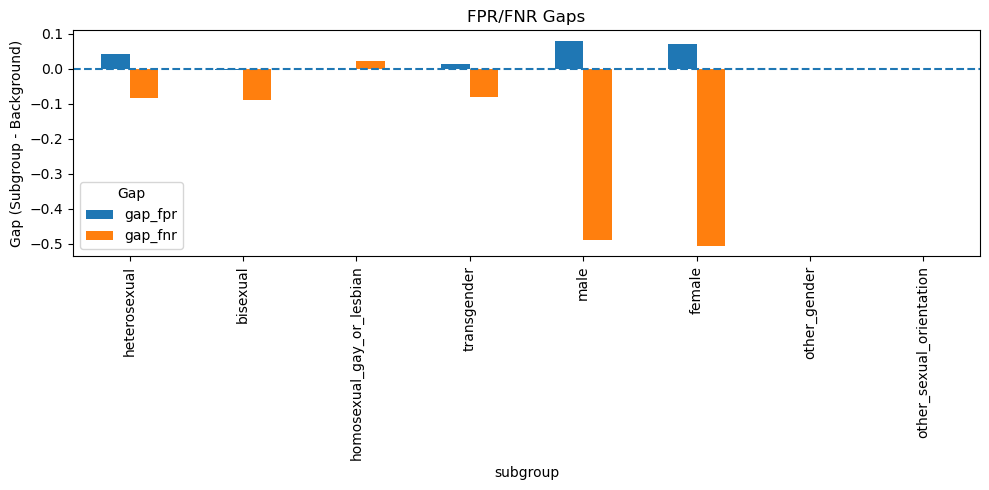

In [19]:
# Visualize fpr/fnr gaps bars
plot_rate_gaps_bars(base_subgroup_metrics_df)
plot_rate_gaps_bars(eo_gender_subgroup_metrics_df)
plot_rate_gaps_bars(eo_sexual_orientation_subgroup_metrics_df)